# Assignment 2: The "Smart Labeling Pipeline" Challenge

**Total Marks: 20**

Build a cost-effective, high-quality labeling pipeline using human annotation, programmatic rules, and LLMs.

This notebook implements an end-to-end smart labeling pipeline to:
1. Establish gold standard through human annotation and measure inter-annotator agreement (6 marks)
2. Label data programmatically using weak supervision (Snorkel) (6 marks)
3. Optimize labeling budget using active learning (5 marks)
4. Leverage LLMs for bulk labeling and detect hallucinations (e.g. noisy labels) (3 marks)

## Setup and Imports

In [1]:
print("Hello World")

Hello World


In [4]:
# Import required libraries
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from statsmodels.stats.inter_rater import fleiss_kappa
import google.generativeai as genai
import time
from pathlib import Path
import re

## Task 1: The Human as Annotator (6 Marks)

**Objective:** Establish a "Gold Standard" dataset and measure human consensus.

### Part 1.1: Parse Annotator CSV Files

After annotating the first 100 reviews, export annotations from three annotators (A, B, C) as CSV files.
Parse these CSV files into clean DataFrames for analysis.

In [3]:
import pandas as pd
import numpy as np

In [ ]:
def parse_annotator_csv(csv_path):
    """
    Parses annotator CSV file into a clean DataFrame.
    
    Args:
        csv_path (str): Path to annotator CSV file
        
    Returns:
        pd.DataFrame: DataFrame with columns ['review_id', 'review', 'label']
                     where label is one of: 'Positive', 'Negative', 'Neutral'
    
    Note:
        - Look for relevant column names in the CSV file
        - If column names differ, the function will try to map them appropriately
        - Finally, return with two columns 'review' and 'label'
    """
    # TODO: Load CSV file using pd.read_csv()

    df=pd.read_csv(csv_path)
    
    rev_col=None
    
    if 'review' in df.columns:
        rev_col = 'review'
    else:
        for c in df.columns:
            col_lower = c.lower()
            if 'review' in col_lower or 'text' in col_lower:
                rev_col = c
                break
    
    label_col = None

    for c in df.columns:
        col_lower = c.lower()
        if 'sentiment' in col_lower or 'choice' in col_lower or 'label' in col_lower:
            label_col = c
            break
    
    cdf=df[[rev_col,label_col]].copy()
    cdf.columns=['review','label']

    return cdf
    
    # TODO: Check and map column names if needed




                                              review     label
0  This movie is a triumph in every sense. Highly...  Positive
1  I have never been so bored in my life. The sco...  Negative
2  I was completely blown away by this film. The ...  Positive
3  The trailer was better than the movie. The act...  Negative
4  Middle of the road entertainment. Visually it'...   Neutral


In [23]:
# TODO: Parse CSV files (replace with actual file paths)
a=parse_annotator_csv("a.csv")
b=parse_annotator_csv("b.csv")
c=parse_annotator_csv("c.csv")
# Display sample data
print(b.head())

                                              review     label
0      /data/upload/3/c163e8d8-movie_reviews_300.csv  Negative
1  This movie is a triumph in every sense. Highly...  Positive
2  I have never been so bored in my life. The sco...  Negative
3  I was completely blown away by this film. The ...  Positive
4  The trailer was better than the movie. The act...  Negative


### Part 1.2: Implement Fleiss' Kappa from Scratch

Measure inter-annotator agreement using Fleiss' Kappa statistic.
Implement the formula from scratch and compare with statsmodels implementation.

In [27]:
def fleiss_kappa_scratch(rating_matrix):
    """
    Computes Fleiss' Kappa for multiple raters from scratch.
    
    Args:
        rating_matrix (np.array): A Count Matrix of shape (N, k).
                                  - N = number of items (rows)
                                  - k = number of categories (columns)
                                  - Element [i, j] = Count of raters who assigned category j to item i.
                                  Example: 
                                    [[0, 0, 3],   # Item 0: All 3 raters said Category 2
                                     [1, 2, 0]]   # Item 1: 1 rater said Cat 0, 2 said Cat 1
                            
    
    Returns:
        float: Kappa score (ranges from -1 to 1, where 1 = perfect agreement)
    
    Formula:
        κ = (P_bar - P_e_bar) / (1 - P_e_bar)
        
        where:
        - P_bar = (1/N) * Σ(P_i) = average proportion of agreement across all items
        - P_i = (1/(n*(n-1))) * Σ(k_ij * (k_ij - 1)) for item i
        - P_e_bar = Σ(p_j^2) = expected agreement by chance
        - p_j = proportion of all assignments to category j
    
    Note:
        - N = number of items (samples)
        - n = number of raters per item (should be constant)
        - k_ij = number of raters who assigned category j to item i
    """
    
    rm = np.array(rating_matrix)
    items,sentiments=rm.shape
    rpi=np.sum(rm[0])

    P_i = []

    for i in range(items):
        row=rm[i]
        numerator = np.sum(row*(row-1))
        P_i.append(numerator/(rpi*(rpi-1)))

    P_bar = np.mean(P_i)

    p_j = np.sum(rm,axis=0)/(items*rpi)

    P_e_bar = np.sum(p_j ** 2)

    fliess_kappa = (P_bar - P_e_bar)/(1-P_e_bar)


    # TODO: Calculate P_bar (observed agreement), P_e_bar (expected agreement by chance), Apply the formula: κ = (P_bar - P_e_bar) / (1 - P_e_bar)
    return fliess_kappa

In [28]:
def prepare_rating_matrix(df_a, df_b, df_c):
    """
    Converts three DataFrames into a rating matrix for Fleiss' Kappa calculation.
    
    Args:
        df_a, df_b, df_c: DataFrames with columns ['review_id', 'review', 'label']
        
    Returns:
        np.array: Rating matrix of shape (N_samples, N_categories)
                  where categories are ['Negative', 'Neutral', 'Positive']
    """
    # TODO: Merge the three DataFrames on review
    # Hint: Use pd.merge() or pd.concat() with proper keys

    merged = pd.merge(df_a, df_b, on='review', suffixes=('_a', '_b'))
    merged = pd.merge(merged, df_c, on='review')
    merged = merged.rename(columns={'label': 'label_c'})

    sentiments = ['Negative', 'Neutral', 'Positive']
    rating_matrix = []

    for _, row in merged.iterrows():
        counts = [0, 0, 0]
        labels = [row['label_a'], row['label_b'], row['label_c']]

        for lab in labels:
            if lab in sentiments:
                idx = sentiments.index(lab)
                counts[idx] += 1

        rating_matrix.append(counts)
    
    return rating_matrix
    

    
    # TODO: Return numpy array of shape (N_samples, 3)
    # Order: [Negative_count, Neutral_count, Positive_count] for each row
    
    

# TODO: Prepare rating matrix and calculate Fleiss' Kappa
rating_matrix=prepare_rating_matrix(a,b,c)
fks=fleiss_kappa_scratch(rating_matrix)
print(fks)
# TODO: Use statsmodels to calculate Fleiss' Kappa
fk=fleiss_kappa(rating_matrix)
print(fk)

# TODO: Print the difference between the two implementations

print("difference = " , fk-fks)

0.8243581715716967
0.8243581715716967
difference =  0.0


### Part 1.3: Conflict Resolution

Identify conflicts where annotators disagree and resolve them using majority vote.
For complete ties (all three differ), default to 'Neutral'.

In [35]:
def resolve_conflicts(df_a, df_b, df_c):
    """
    Merges annotations from 3 annotators, resolves disagreements using Majority Vote,
    and handles complete ties by defaulting to 'Neutral'.
    
    Args:
        df_a, df_b, df_c: DataFrames from each annotator with columns ['review', 'label']
        
    Returns:
        pd.DataFrame: Final DataFrame with resolved labels (gold standard)
                     Columns: ['review', 'label']
    
    Logic:
        - Majority Vote: If 2 annotators agree, use their label
        - Tie-Breaker: If all 3 differ (e.g., Positive vs. Negative vs. Neutral), assign 'Neutral'
    """
    merged = pd.merge(df_a, df_b, on='review', suffixes=('_a', '_b'))
    merged = pd.merge(merged, df_c, on='review')
    merged = merged.rename(columns={'label': 'label_c'})

    def is_conflict(row):
        labels = {row["label_a"], row["label_b"], row["label_c"]}
        return len(labels) > 1
    
    conflicts = merged[merged.apply(is_conflict, axis=1)]

    examples_to_show = min(5, len(conflicts))

    for i in range(examples_to_show):
        row = conflicts.iloc[i]

        print(" Conflict Example", i+1)
        print("Review:", row["review"])
        print("Annotator A:", row["label_a"])
        print("Annotator B:", row["label_b"])
        print("Annotator C:", row["label_c"])


    final_labels=[]

    for index , row in merged.iterrows():
        labels = [row['label_a'], row['label_b'], row['label_c']]

        label_counts = {}
        for label in labels:
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1
    
        majority_label = None
        for label, count in label_counts.items():
            if count >= 2:
                majority_label = label
                break

        if majority_label is None:
            majority_label = "Neutral"

        final_labels.append(majority_label)

    gold_standard = pd.DataFrame({
        "review": merged["review"],"label": final_labels})
    
    return gold_standard
    
    

In [37]:
# TODO: Resolve conflicts and create gold standard
gold_standard = resolve_conflicts(a,b,c)
# TODO: Display 5 examples of conflicting reviews (if <5 reviews, show all)
print('\n' , '='*50 , '\n')
# Show what A, B, and C each said, and the final resolved label
print(gold_standard.head())
# TODO: Save gold standard to CSV
gold_standard.to_csv("gold_standard_reviews.csv",index=False)

 Conflict Example 1
Review: I oscillated between loving and hating this film. I respect the ambition, even if it didn't fully land.
Annotator A: Positive
Annotator B: Positive
Annotator C: Neutral
 Conflict Example 2
Review: It tries to be deep, but comes off as dull despite the gripping music. A strange experience overall.
Annotator A: Negative
Annotator B: Neutral
Annotator C: Neutral
 Conflict Example 3
Review: I am confused about how I feel. It left me puzzled.
Annotator A: Positive
Annotator B: Neutral
Annotator C: Neutral
 Conflict Example 4
Review: I have mixed feelings about this one. You won't remember it a week from now.
Annotator A: Negative
Annotator B: Neutral
Annotator C: Neutral
 Conflict Example 5
Review: Great concept, but the execution was jarring. It’s a weird mix of brilliance and stupidity.
Annotator A: Neutral
Annotator B: Negative
Annotator C: Neutral


                                              review     label
0  This movie is a triumph in every sense. Highl

## Task 2: Weak Supervision (The "Lazy" Labeler) (6 Marks)

**Objective:** Label the next 200 reviews programmatically to save time.

### Part 2.1: Heuristic Development

Analyze patterns in the gold standard and write at least 3 heuristic functions.
Apply them to the remaining 200 unlabeled reviews.

In [8]:
# Constants for labeling functions
POSITIVE = 1
NEGATIVE = 0
NEUTRAL = 2
ABSTAIN = -1

# TODO: Load gold standard to analyze patterns
gold_standard_df = pd.read_csv("gold_standard_reviews.csv")

# TODO: Analyze patterns (e.g., common positive/negative words, review length, etc.)
# This will help you design effective heuristics

### Part 2.2: Snorkel Labeling Functions

Wrap your heuristics as Snorkel @labeling_function decorators.
Each function should return POSITIVE (1), NEGATIVE (0), NEUTRAL (2), or ABSTAIN (-1).

In [5]:
@labeling_function()
def lf_keyword_great(x):
    """
    Example labeling function: Check if "great" appears in the review.
    Returns POSITIVE if found, otherwise ABSTAIN.
    """
    # TODO: Check if "great" (case-insensitive) is in x.review

    if "great" in x.review.lower():
        return POSITIVE
    return ABSTAIN
    
    # Return POSITIVE if found, ABSTAIN otherwise
    

@labeling_function()
def lf_short_review(x):
    """
    Label based on review length.
    Very short reviews might be neutral or indicate lack of engagement.
    """
    # TODO: Implement logic based on review length

    if len(x.review.split()) < 15:
        return NEUTRAL
    return ABSTAIN

    # Return appropriate label (NEUTRAL for very short, or ABSTAIN)
    pass

@labeling_function()
def lf_regex_bad(x):
    """
    Use regex to find negative patterns.
    Look for words like "horrible", "terrible", "awful", etc.
    """
    # TODO: Use regex or string matching to find negative keywords
    badwords = ["bad", "boring", "dull", "terrible", "awful", "disappointing","poor", "weak", "predictable", "messy", "slow", "dragged","annoying", "waste", "forgettable", "flat", "lifeless", "hate"]
    for bad in badwords:
        if bad in x.review.lower():
            return NEGATIVE
    return ABSTAIN    
    # Return NEGATIVE if found, ABSTAIN otherwise
    pass

# TODO: Write at least 3 more labeling functions (minimum 6 total)

@labeling_function()
def lf_average_neutral(x):
    avgwords = ["okay", "fine", "average", "decent", "mixed", "uneven","middle", "passable", "serviceable", "alright"]
    for avg in avgwords:
        if avg in x.review.lower():
            return NEUTRAL
    return ABSTAIN

@labeling_function()
def lf_mixed_phrase(x):
    phrases = ["not a masterpiece","not a disaster","middle of the road","it is what it is","serviceable"]
    for p in phrases:
        if p in x.review.lower():
            return NEUTRAL
    return ABSTAIN

@labeling_function()
def lf_strong_positive(x):
    goodwords = ["good", "great", "amazing", "excellent", "superb", "fantastic","enjoyable", "fun", "engaging", "compelling", "impressive","beautiful", "powerful", "heartwarming", "brilliant","loved", "love", "masterpiece", "recommend", "worth"]
    for good in goodwords:
        if good in x.review.lower():
            return POSITIVE
    return ABSTAIN

### Part 2.3: Apply Labeling Functions and Analyze Coverage

Apply all labeling functions to the 200 unlabeled reviews and calculate coverage and conflict rates.

In [9]:
def analyze_weak_labels(L_matrix, lfs):
    """
    Prints Coverage and Conflict statistics for the Labeling Functions.
    
    Args:
        L_matrix (np.array): Label matrix of shape (N_samples, N_functions)
                            Each column represents one labeling function's outputs
                            Values: POSITIVE (1), NEGATIVE (0), NEUTRAL (2), ABSTAIN (-1)
        lfs: List of labeling functions (for display names)
    
    Metrics to calculate:
        - Coverage: Percentage of non-abstain votes per LF
        - Conflict Rate: Percentage of samples where LFs disagree
    """
    # TODO: Calculate coverage for each labeling function
    # Coverage = (number of non-abstain votes) / (total samples) * 100
    L = np.array(L_matrix)
    n_samples, n_lfs = L.shape

    for i in range(n_lfs):
        non_abstain = np.sum(L[:, i] != ABSTAIN)
        coverage = (non_abstain / n_samples) * 100
        print(f"{lfs[i].name}: {coverage:.2f}%")

    # TODO: Calculate conflict rate
    # Conflict occurs when multiple LFs label the same sample differently
    # Conflict Rate = (number of conflicting samples) / (total samples) * 100

    conflicts = 0

    for row in L:
        labels = row[row != ABSTAIN]  # remove abstains
        if len(labels) > 1 and len(set(labels)) > 1:
            conflicts += 1

    conflict_rate = (conflicts / n_samples) * 100
    # TODO: Print statistics in a readable format
    print(f"Conflicting samples: {conflicts}")
    print(f"Conflict rate: {conflict_rate:.2f}%")
    # Hint: Use LFAnalysis from snorkel for detailed stats (optional)
    # Or print manually: LF name, Coverage %, Conflicts count
    
    pass

    
    

# TODO: Load the 200 unlabeled reviews (you can load the entire dataset and then filter as per the requirement)
df_all = pd.read_csv("movie_reviews_300.csv")

df_unlabeled = df_all.iloc[100:]
print(df_unlabeled.shape)  


# TODO: Apply all labeling functions to create L_matrix
lfs = [lf_keyword_great, lf_short_review, lf_regex_bad,lf_average_neutral,lf_mixed_phrase,lf_strong_positive ]  # Add all your LFs
applier = PandasLFApplier(lfs=lfs)
L_matrix = applier.apply(df=df_unlabeled)

analyze_weak_labels(L_matrix, lfs)

# TODO: Analyze coverage and conflicts
L_matrix=np.array(L_matrix).copy()

# TODO: Use LFAnalysis for detailed statistics
analysis = LFAnalysis(L=L_matrix, lfs=lfs).lf_summary()
print(analysis)

(220, 1)


100%|██████████| 220/220 [00:00<00:00, 3080.25it/s]

lf_keyword_great: 5.00%
lf_short_review: 28.18%
lf_regex_bad: 13.64%
lf_average_neutral: 17.73%
lf_mixed_phrase: 6.36%
lf_strong_positive: 30.00%
Conflicting samples: 39
Conflict rate: 17.73%
                    j Polarity  Coverage  Overlaps  Conflicts
lf_keyword_great    0      [1]  0.050000  0.050000   0.009091
lf_short_review     1      [2]  0.281818  0.131818   0.104545
lf_regex_bad        2      [0]  0.136364  0.072727   0.072727
lf_average_neutral  3      [2]  0.177273  0.118182   0.077273
lf_mixed_phrase     4      [2]  0.063636  0.059091   0.040909
lf_strong_positive  5      [1]  0.300000  0.186364   0.145455



c:\Users\Vasu\AppData\Local\Programs\Python\Python312\Lib\site-packages\snorkel\labeling\analysis.py:61: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  m = sparse.diags(np.ravel(self._L_sparse.max(axis=1).todense()))


### Part 2.4: Majority Vote Adjudication

Use majority vote to generate probabilistic labels (weak labels) for the 200 reviews.
Save the result to `weak_labels_200.csv`.

In [10]:
# TODO: Train LabelModel to get probabilistic labels
L_matrix=np.array(L_matrix)
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_matrix, n_epochs=500, log_freq=100, seed=42)

probs = label_model.predict_proba(L_matrix)
pred_labels = label_model.predict(L_matrix)

# TODO: Convert numeric labels to match your label scheme
# Label mapping: 0 -> 'Negative' (or 0), 1 -> 'Positive' (or 1), 2 -> 'Neutral' (or 2), -1 -> 'Abstain'
labelmap = { 0: "Negative",1: "Positive",2: "Neutral",-1: "Abstain"}

text_labels = [labelmap[l] for l in pred_labels]


# TODO: Create DataFrame with reviews and weak labels
weak_labels = df_unlabeled.copy()

weak_labels["weak_label"] = text_labels
weak_labels["probably_negative"] = probs[:, 0]
weak_labels["probably_positive"] = probs[:, 1]
weak_labels["probably_neutral"] = probs[:, 2]

print(weak_labels)
# TODO: Save to CSV
weak_labels.to_csv("weak_labels_snorkel.csv", index=False)


INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 704.38epoch/s]
INFO:root:Finished Training


                                                review weak_label  \
100  It’s a weird mix of brilliance and stupidity. ...   Positive   
101  I struggled to sit through the first half. Not...   Positive   
102  I struggled to sit through the first half. The...    Abstain   
103  I'm honestly still trying to process what I ju...    Abstain   
104  A refreshing take on a tired genre. It perfect...    Abstain   
..                                                 ...        ...   
315  This might be the worst thing I've seen all ye...    Abstain   
316  Neither good nor bad, just exists. It is what ...    Neutral   
317  The lead actor delivered a heartwarming perfor...   Positive   
318  The pacing was absolutely touching. Wow, just ...    Neutral   
319  A frustrating experience. The plot holes were ...    Neutral   

     probably_negative  probably_positive  probably_neutral  
100           0.000666           0.997794          0.001541  
101           0.114211           0.621343      

## Task 3: Active Learning (The Budget Optimizer) (5 Marks)

**Objective:** Simulate cost savings by training a model iteratively.

### Part 3.1: Query Strategy Implementation

Implement Least Confidence and Entropy Sampling from scratch.
These strategies select the most informative samples for labeling.

In [ ]:
def least_confidence_sampling(model, X_pool, n_instances=10):
    """
    Selects samples where the model is least confident (uncertainty sampling).
    
    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select
    
    Returns:
        np.array: Indices of selected samples
    Strategy:
        Uncertainty = 1 - max(probability) across all classes
        For 3-class classification: Get probabilities for [Negative, Positive, Neutral]
        Select samples with highest uncertainty (lowest max probability)
    """
    probs = model.predict_proba(X_pool)
    uncertainty = 1 - np.max(probs, axis=1)
    query_indices = np.argsort(uncertainty)[-n_instances:]
    return query_indices



def entropy_sampling(model, X_pool, n_instances=10):
    """
    Selects samples with highest entropy (information gain).
    
    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select
    
    Returns:
        np.array: Indices of selected samples
    Strategy:
        Entropy = -sum(p * log(p)) for all classes
        For 3-class classification: Calculate entropy across [Negative, Positive, Neutral] probabilities
        Select samples with highest entropy (most uncertain across all classes)
    """
    probs = model.predict_proba(X_pool)
    epsilon = 1e-9
    entropy = -np.sum(probs * np.log(probs + epsilon), axis=1)
    query_indices = np.argsort(entropy)[-n_instances:]
    return query_indices




def random_sampling(model, X_pool, n_instances=10):
    """
    Baseline strategy: Selects random samples.
    
    Args:
        model: Not used, but kept for interface consistency
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select
    
    Returns:
        np.array: Randomly selected indices
    """
    n_instances = min(n_instances, len(X_pool))
    query_indices = np.random.choice(len(X_pool), size=n_instances, replace=False)
    return query_indices


### Part 3.2: Data Processing and Setup

Load the gold standard (seed) and weak labels (pool).
Create a static test set from the pool for evaluation.
Vectorize text data using TF-IDF.

In [45]:
def load_and_process_data():
    """
    Loads and processes data for active learning.
    
    Returns:
        Tuple: (X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer)
               All X are feature matrices, all y are label arrays
               vectorizer is returned for later use on LLM data
               
    Note:
        - Seed: gold_standard_100.csv (100 labeled reviews)
        - Pool: weak_labels_200.csv (200 reviews, labels treated as hidden for simulation)
        - Test: Hold out 50 samples from pool (weak labels) for static evaluation
        - We use 3-class classification: Positive (1), Negative (0), Neutral (2)
        - Uncertainty metrics use probability scores across all three classes:
          * Least Confidence: 1 - max(probabilities) across all classes
          * Entropy: -sum(p * log(p)) for all three classes
    """

    df_seed = pd.read_csv('gold_standard_reviews.csv')
    df_pool_full = pd.read_csv('weak_labels_snorkel.csv')
    
    df_pool_full = df_pool_full[df_pool_full['weak_label'] != 'Abstain'].reset_index(drop=True)
    
    # Map text labels to numeric: Positive=1, Negative=0, Neutral=2
    label_mapping = {
        'Positive': 1, 'positive': 1, 'POSITIVE': 1,
        'Negative': 0, 'negative': 0, 'NEGATIVE': 0,
        'Neutral': 2, 'neutral': 2, 'NEUTRAL': 2
    }
    
    # Identify label columns
    label_col_seed = 'label'
    label_col_pool = 'weak_label'
    
    # Convert seed labels
    df_seed['sentiment_numeric'] = df_seed[label_col_seed].map(label_mapping)
    
    # Convert pool labels
    df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].map(label_mapping)
    
    # Create static test set (hold out 50 samples from pool)
    df_pool, df_test = train_test_split(df_pool_full, test_size=50, random_state=42)
    
    
    # Vectorize text data using TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    all_text = pd.concat([df_seed['review'], df_pool['review'], df_test['review']])
    vectorizer.fit(all_text)
    
    # Transform datasets to feature matrices
    X_seed = vectorizer.transform(df_seed['review']).toarray()
    X_pool = vectorizer.transform(df_pool['review']).toarray()
    X_test = vectorizer.transform(df_test['review']).toarray()
    
    # Extract numeric labels
    y_seed = df_seed['sentiment_numeric'].values
    y_pool = df_pool['sentiment_numeric'].values
    y_test = df_test['sentiment_numeric'].values
    
    return X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer

X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer = load_and_process_data()

print(f"Seed Size: {len(y_seed)}")
print(f"Pool Size: {len(y_pool)} (Available for querying)")
print(f"Test Size: {len(y_test)} (Held out for evaluation)")



Seed Size: 99
Pool Size: 93 (Available for querying)
Test Size: 50 (Held out for evaluation)


### Part 3.3: Active Learning Loop

Implement the iterative active learning loop:
1. Train model on current training set
2. Query uncertain samples from pool
3. "Label" them (reveal ground truth)
4. Add to training set and retrain
5. Log test accuracy

In [46]:


def run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test,
                             strategy_func, steps=5, batch_size=10):
    """
    Simulates the active learning loop.
    
    Args:
        X_seed, y_seed: Initial training data (seed set)
        X_pool, y_pool: Unlabeled pool (y_pool is hidden, revealed during query)
        X_test, y_test: Static test set for evaluation
        strategy_func: Function that selects samples
        steps: Number of iterations
        batch_size: Number of samples to query per iteration
    
    Returns:
        Tuple: (n_labels_history, accuracy_history)
            Lists tracking number of labels and test accuracy over iterations.
    """
    X_train = X_seed.copy()
    y_train = y_seed.copy()
    
    X_pool_curr = X_pool.copy()
    y_pool_curr = y_pool.copy()
    
    accuracy_history = []
    n_labels_history = []
    
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, model.predict(X_test))
    accuracy_history.append(acc)
    n_labels_history.append(len(y_train))
    print(f"Initial — Labels: {len(y_train)}, Test Accuracy: {acc:.4f}")
    
    for i in range(steps):
        if len(X_pool_curr) == 0:
            print(f"Pool exhausted at step {i}")
            break
        
        actual_batch = min(batch_size, len(X_pool_curr))
        
        query_indices = strategy_func(model, X_pool_curr, n_instances=actual_batch)
        
        X_new = X_pool_curr[query_indices]
        y_new = y_pool_curr[query_indices]
        
        X_train = np.vstack([X_train, X_new])
        y_train = np.concatenate([y_train, y_new])
        
        X_pool_curr = np.delete(X_pool_curr, query_indices, axis=0)
        y_pool_curr = np.delete(y_pool_curr, query_indices, axis=0)
        
        model.fit(X_train, y_train)
        
        acc = accuracy_score(y_test, model.predict(X_test))
        accuracy_history.append(acc)
        n_labels_history.append(len(y_train))
        print(f"Step {i+1} — Labels: {len(y_train)}, Test Accuracy: {acc:.4f}")
    
    return n_labels_history, accuracy_history

# Run active learning with least confidence strategy
print("=== Least Confidence Sampling ===")
n_labels_lc, acc_lc = run_active_learning_loop(
    X_seed, y_seed, X_pool, y_pool, X_test, y_test,
    strategy_func=least_confidence_sampling, steps=5, batch_size=10
)




=== Least Confidence Sampling ===
Initial — Labels: 99, Test Accuracy: 0.5400
Step 1 — Labels: 109, Test Accuracy: 0.6600
Step 2 — Labels: 119, Test Accuracy: 0.6800
Step 3 — Labels: 129, Test Accuracy: 0.7200
Step 4 — Labels: 139, Test Accuracy: 0.7200
Step 5 — Labels: 149, Test Accuracy: 0.7200


### Part 3.4: Visualization and Comparison

Plot learning curves comparing Active Learning vs. Random Sampling.

=== Random Sampling (Baseline) ===
Initial — Labels: 99, Test Accuracy: 0.5400
Step 1 — Labels: 109, Test Accuracy: 0.6200
Step 2 — Labels: 119, Test Accuracy: 0.6400
Step 3 — Labels: 129, Test Accuracy: 0.6200
Step 4 — Labels: 139, Test Accuracy: 0.6400
Step 5 — Labels: 149, Test Accuracy: 0.7000


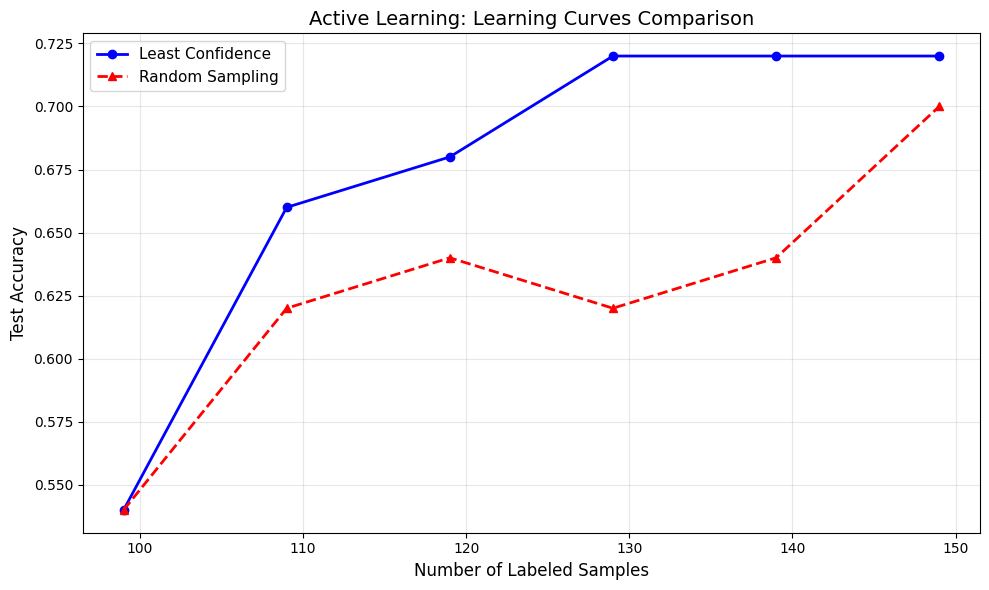


=== Final Accuracy Comparison ===
Least Confidence: 0.7200 (with 149 labels)
Random Sampling:  0.7000 (with 149 labels)


In [47]:

# Run active learning with random sampling (baseline)
print("=== Random Sampling (Baseline) ===")
np.random.seed(42)
n_labels_rand, acc_rand = run_active_learning_loop(
    X_seed, y_seed, X_pool, y_pool, X_test, y_test,
    strategy_func=random_sampling, steps=5, batch_size=10
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(n_labels_lc, acc_lc, 'b-o', label='Least Confidence', linewidth=2)
plt.plot(n_labels_rand, acc_rand, 'r--^', label='Random Sampling', linewidth=2)
plt.xlabel('Number of Labeled Samples', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Active Learning: Learning Curves Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print comparison summary
print("\n=== Final Accuracy Comparison ===")
print(f"Least Confidence: {acc_lc[-1]:.4f} (with {n_labels_lc[-1]} labels)")
print(f"Random Sampling:  {acc_rand[-1]:.4f} (with {n_labels_rand[-1]} labels)")


## Task 4: AI vs. AI (LLM & Noise Detection) (3 Marks)

**Objective:** Use LLMs for bulk labeling and detect hallucinations.

**Note:**

- Make an account at [open-router](https://openrouter.ai/) and get the API key.
- Use `google/gemini-2.5-flash-lite` (free tier) model as your LLM. Read the documentation on how to use it [here](https://openrouter.ai/google/gemini-2.5-flash-lite/api)
- Set environment variable using .env file and paste your API key in it.

### Part 4.1: LLM Pipeline with Few-Shot Prompting

Design a few-shot prompt with 3 examples from gold standard.
Send remaining unlabeled samples (~150) to Gemini API for labeling.

In [ ]:

import os
import time
import json
import requests
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv('OPENROUTER_API_KEY')
SITE_URL = "http://localhost:8000"  #for OpenRouter rankings
SITE_NAME = "Student Lab Assignment"

MODEL_NAME = "google/gemini-2.5-flash-lite"

if not API_KEY:
    print("⚠ Warning: OPENROUTER_API_KEY not found. Please check your .env file.")


def generate_few_shot_prompt(review_text, examples):
    """
    Constructs a few-shot prompt with 3 gold examples + target review.
    
    Args:
        review_text (str): The review to be labeled
        examples (list): List of 3 example dictionaries with 'review' and 'label' keys
    
    Returns:
        str: Formatted prompt string
    """
    
    pass

def query_openrouter(review_text, examples):
    """
    Sends request to OpenRouter API with retry logic and parsing.
    
    Args:
        review_text (str): Review to classify
        examples (list): Few-shot examples (list of dicts with 'review' and 'label')
    
    Returns:
        str: Label ('Positive', 'Negative', or 'Neutral')
             Returns None if API fails or response is invalid
    
    Note:
        - Uses OpenRouter API endpoint: https://openrouter.ai/api/v1/chat/completions
        - Implements retry logic for rate limit errors (429)
        - Parses response from OpenRouter's chat completions format
    """
    url = "https://openrouter.ai/api/v1/chat/completions"
    
    # TODO: Set up headers:
    
    # TODO: Generate prompt using generate_few_shot_prompt()
    
    # TODO: Create payload dictionary:
    
    # TODO: Implement retry logic:
    
    # TODO: Parse successful response:
    
    pass

# --- MAIN EXECUTION ---

# TODO: Load gold standard examples for few-shot prompting

# TODO: Load remaining unlabeled reviews (~150, select last 150 from movie_reviews_300.csv)


# TODO: Query OpenRouter for each review
# Handle free tier requests per minute (RPM) limit of ~15

# TODO: Save LLM labels, in csv format with 'review' and 'label' columns

### Part 4.2: Noise Hunting (Cleanlab Logic)

Train a Logistic Regression model on LLM-labeled data.
Identify "High Confidence Disagreements" where the model is very confident (>0.80) but disagrees with the LLM label.

In [ ]:
def find_label_errors(llm_labels, model_probs, review_texts, threshold=0.90):
    """
    Detects high-confidence disagreements between model predictions and LLM labels.
    This implements Cleanlab logic: find cases where model is confident but disagrees with LLM.
    
    Args:
        llm_labels: List/array of labels from Gemini (numeric: 0=Negative, 1=Positive, 2=Neutral)
        model_probs: Probability matrix from Logistic Regression (shape: N_samples, N_classes)
        review_texts: List of review texts (for display)
        threshold: Confidence threshold (default 0.90)
    
    Returns:
        list: List of dictionaries with suspicious review information
              Each dict contains: 'index', 'text', 'llm_label', 'model_pred', 'confidence'
    """
    # TODO: Get model predictions from probabilities

    
    # TODO: Get model confidence (max probability) for each sample

    
    # TODO: Convert llm_labels to numeric if they are strings
    # Map 'Positive'->1, 'Negative'->0, 'Neutral'->2
    
    # TODO: Find disagreements where:
    #   Hint: disagreement_mask = (preds != llm_labels) & (confidences > threshold)
    
    # TODO: Create list of suspicious reviews with all relevant information (llm label, model prediction, confidence)

    
    # TODO: Sort by confidence (highest first) to find most egregious errors
    
    # TODO: Return list of suspicious reviews
    pass


# TODO: Load LLM labels in dataframe

# TODO: Vectorize LLM-labeled reviews (use same vectorizer from Task 3)

# TODO: Train Logistic Regression on LLM-labeled data
# Use same model configuration as Task 3 for consistency

# TODO: Get probabilities on the same data (self-check), shape should be (N_samples, N_classes)

# TODO: Find label errors using your function

# TODO: Print top 5 suspicious reviews (if <5, print all)

## Deliverables

**Submission Checklist:**
- [ ] Completed Jupyter Notebook with all tasks (Tasks 1-4)
- [ ] Include your label-studio annotation interface screenshot.
- [ ] gold_standard_100.csv
- [ ] weak_labels_200.csv
- [ ] llm_labels_150.json